<a href="https://colab.research.google.com/github/Guillem96/activity-recognition/blob/master/notebooks/Matching_SIFT_Features_Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matching SIFT Features Annotation

In this notebook, I go over a basic SIFT descriptors explanation, how to implement it using OpenCV, and finally how we can potentially use them in Video Activity recognition.

## Preparing the environment

Before we can start, SIFT algorithm is patented and we cannot directly use with OpenCV. To use it, we have to re-compile OpenCV changing some compilation flags. 
Another option, which is not the best but the quickest, is to downgrade the OpenCV python package to 3.x version.

In [1]:
!pip uninstall -y opencv-python
!pip install opencv-contrib-python==3.4.2.17

Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 133kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


## What are SIFT descriptors?

In the image feature extraction literature we can find a lot of different techniques to extract the image edges and corners \[1\]. For instance, a well known method is [Harris Corner Detection](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html). Most of this methods are based in rotation, in the sense that when rotating an image the corners and edges are still edges.

What what happens when the image is scaled? The previous methods will fail when scaling images. Luckily, we have the SIFT algorithm, which is described in \[2\]. With SIFT we can get image keypoints along keypoints' descriptors.


To see how we obtain SIFT features we are going to download two Notre Dame 
 images, and later, we are going to try to guess the correspondences between those images.

In [2]:
!wget -O im1.jpg https://www.reasonwhy.es/sites/default/files/marcas_notre_dame.jpg
!wget -O im2.jpg "https://www.aciprensa.com/imagespp/Catedral-Notre-Dame-Pixabay-30052019.jpg"

--2020-07-05 08:26:57--  https://www.reasonwhy.es/sites/default/files/marcas_notre_dame.jpg
Resolving www.reasonwhy.es (www.reasonwhy.es)... 104.31.88.167, 104.31.89.167, 172.67.182.182, ...
Connecting to www.reasonwhy.es (www.reasonwhy.es)|104.31.88.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163892 (160K) [image/jpeg]
Saving to: ‘im1.jpg’

im1.jpg             100%[===================>] 160.05K  --.-KB/s    in 0.008s  

2020-07-05 08:26:57 (20.0 MB/s) - ‘im1.jpg’ saved [163892/163892]

--2020-07-05 08:27:00--  https://www.aciprensa.com/imagespp/Catedral-Notre-Dame-Pixabay-30052019.jpg
Resolving www.aciprensa.com (www.aciprensa.com)... 172.67.169.163, 104.28.3.213, 104.28.2.213, ...
Connecting to www.aciprensa.com (www.aciprensa.com)|172.67.169.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘im2.jpg’

im2.jpg                 [  <=>               ]  70.95K   324KB/s    in 0.2s    

2020-

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

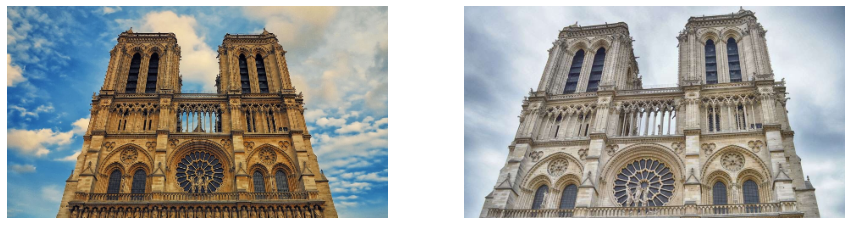

In [6]:
def imshow(im):
  plt.imshow(np.flip(im, -1))
  plt.axis('off')

def plot_images(im1, im2):
  plt.subplot(121)
  imshow(im1)
  
  plt.subplot(122)
  imshow(im2)
  plt.show()

im1 = cv2.imread('im1.jpg')
im1 = cv2.resize(im1, (450, 250))
im2 = cv2.imread('im2.jpg')
im2 = cv2.resize(im2, (450, 250))

plt.figure(figsize=(15, 8))
plot_images(im1, im2)

SIFT algorithm steps are:

1. **Find local extremas in different image scales**: SIFT generates $n$ octaves for the input image. For each octave, SIFT generates $s$ different scaled images using a gausian filter. For example, at octave $n$ we generate $s = 5$ scales of the same image applying $k\sigma$, where $k$ and $\sigma$ are hyperparameters.


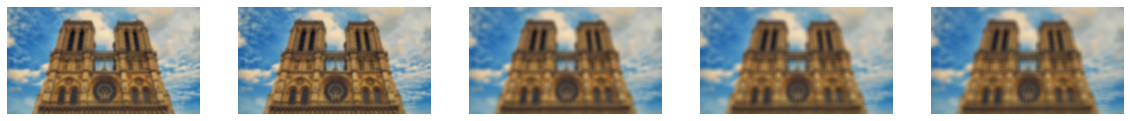

In [14]:
k = np.sqrt(2)
sigma = 1.6
s = 5

plt.figure(figsize=(20, 8))
for i in range(s):
  plt.subplot(1, s, i + 1)
  im_out = cv2.GaussianBlur(im1, (13, 13), 
                            sigmaX=sigma * k * i, sigmaY=sigma * k * i)
  imshow(im_out)

SIFT goes one step further and computes the difference between the different scales, thus generating a Difference of Gaussian (DoG).
Finally, SIFT looks for local extemas computing differences between pixel neighbours in the same and other scale images

![](https://docs.opencv.org/master/sift_local_extrema.jpg)




2. **Filter local extrmas to find keypoints**: Remove local extremas under a threshold, and filter the edges found using the *eigenvalues rule* descirbed by Harris in \[1\].

3. **Orientation Assignment**: Now an orientation is assigned to each keypoint to achieve invariance to image rotation. A neighbourhood is taken around the keypoint location depending on the scale, and the gradient magnitude and direction is calculated in that region. SIFT does so weighting a HOG with a gaussian window.

4. **Generate descriptors for each point**:  16x16 neighbourhood around the keypoint is taken. It is divided into 16 sub-blocks of 4x4 size. For each sub-block, 8 bin orientation histogram is created. So a total of 128 bin values are available.

## OpenCV SIFT


Now that we know how SIFT works, we are ready to go through an OpenCV example.


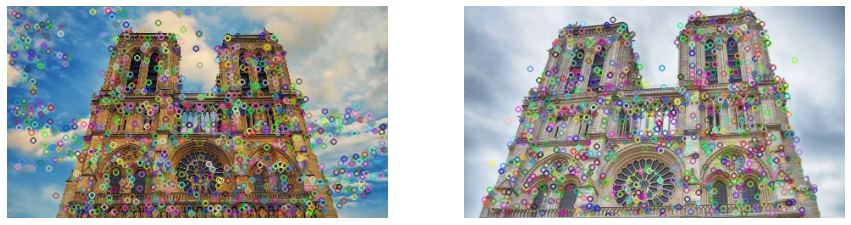

In [16]:
def get_kp_descriptors(im):
  gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  sift = cv2.xfeatures2d_SIFT.create()
  return sift.detectAndCompute(gray_image, None)

kp1, desc1 = get_kp_descriptors(im1)
kp2, desc2 = get_kp_descriptors(im2)

output1 = cv2.drawKeypoints(im1, kp1, None)
output2 = cv2.drawKeypoints(im2, kp2, None)

plt.figure(figsize=(15, 8))
plot_images(output1, output2)

As mentioned below descriptors will have 128 features.

In [17]:
desc1.shape, desc2.shape

((1174, 128), (1090, 128))

## Matching SIFT features

In this section we are going to find correspondences among two images. In Video activity recognition, we can find SIFT features matching between two consecutive frame and generate Dense Trajectories \[3\].

Keypoints between two images are matched by identifying their nearest neighbours. But in some cases, the second closest-match may be very near to the first. It may happen due to noise or some other reasons. In that case, ratio of closest-distance to second-closest distance is taken. If it is greater than 0.8, they are rejected. It eliminates around 90% of false matches while discards only 5% correct matches, as per the paper.

To simplify the procedure, we just compute the L2 distance and pick the closest descriptor.

In [19]:
distances = np.sqrt(np.sum(np.power(np.expand_dims(desc1, 1) - desc2, 2), -1))
matches = np.argmin(distances, -1)
min_distances = distances[np.arange(matches.shape[0]), matches]

In [20]:
sample_rate = .03
n_matches = int(matches.shape[0] * sample_rate)
top_matches = np.argsort(min_distances)[:n_matches]

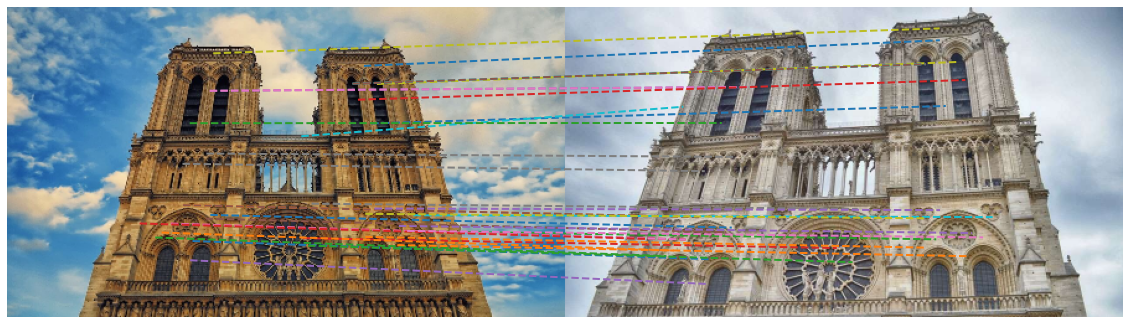

In [21]:
full_image = np.concatenate([im1, im2], axis=1)
plt.figure(figsize=(20, 20))
plt.imshow(np.flip(full_image, -1))
for i in top_matches.tolist():
  kp_from_1 = kp1[i].pt
  kp_from_2 = kp2[matches[i]].pt
  kp_from_2 = kp_from_2[0] + im1.shape[1], kp_from_2[1]
  plt.plot([kp_from_1[0], kp_from_2[0]], 
           [kp_from_1[1], kp_from_2[1]],
           '--', linewidth=2)
plt.axis('off');

## References 

- \[1\] [A Combined Corner and Edge Detector](https://pdfs.semanticscholar.org/6818/668fb895d95861a2eb9673ddc3a41e27b3b3.pdf)

- \[2\] [Distinctive Image Features from Scale-Invariant Keypoints](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)

- \[3\] (Action Recognition by Dense Trajectories)[https://hal.inria.fr/inria-00583818/document]